In [ ]:
"""
  Plotting and fitting functions have been modularized outside
  of this code instead of being integrated throughout.

  Use FOUR fluxes to compute PDR parameters.
  
  Finds matching pixels for all emission lines before PDR fitting.

  Computes the TIR using the 60 um and 100 um continuum flux.

  Fit the continuum fluxes with a modified blackbody,
  in the optically thin emission approximation.

  Plot the fitted greybody spectrum and colormaps of the
  dust temperature and dust mass.

  Compute the PDR parameters nH and G0 using an online
  PDR Toolbox. Make colormaps of those results.
"""

In [1]:
# Standard
import numpy as np
import os
from functools import partial
from numpy import ma
# Related
import collections
import pickle
import scipy.ndimage
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from pyspeckit.parallel_map import parallel_map
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.axes_grid import AxesGrid
from matplotlib.backends.backend_pdf import PdfPages
import pywcsgrid2
# Local
from pdrModelingThings import (fir, plotGBFit,
                               cMapFirTir, cMapDustTempMass,
                               cMapPdrParams4Fluxes,
                               cMapPdrParams4FluxesNoWcs)#greybody)
from fitsThings import createHdu, buildWcsOh
from cleanImageThings import cleanImage
from fluxThings import calcTotIntFluxes
from dictionaryThings import (saveDict,loadDict,buildConvolvedLineProfDict,
                              buildAllLineWcsLimits)
from functionThings import gaussFunc,waveToVel,velToWave
from maskThings import maskTrue
from outlierThings import getIndices,findNeighbors
from pdrt_getvaluesV2 import pdrt_getvaluesV2
from pdrt_getvaluesV3 import pdrt_getvaluesV3
from pixelThings import pixMinMax,findValidPixels
from plotThings import lineRatios
from ObsInfo import ObsInfo
# --------------------------------------------------- #

## This static function returns the grey body flux(Jy) for the specified
# wavelength or wavelengths (micron), for the given observer distance D(pc),
# power-law exponent beta, opacity kappa at 350 micron (m2/kg),
# dust temperature T(K) and dust mass M(Msun).
def greybody(wave,T,M):
    nu = c / (wave*1.e-6)                                   # Hz
    nu350 = c / 350.e-6                                     # Hz
    kappa = kappa350 * (nu/nu350)**beta                     # m2/kg
    Bnu = 2*h*nu**3/ c**2 / (np.exp((h*nu)/(k*T)) - 1)      # W/m2/Hz
    flux = M*Msun * kappa * Bnu / (D*pc)**2                 # W/m2/Hz
    return flux * 1.e26                                     # Jy

## Compute the FIR total integrated flux (W/m2) from 42.5um to 122.5um using
# the flux densities(Jy) of the greybody SED at 60um and 100um. (Helou1998)
def fir(i60,i100):
    return 1.26e-14*((2.58*i60)+i100)



if __name__ == '__main__':

    # ----------------------------- #
    # Universal constants and units #
    # ----------------------------- #
    c = 2.99792458e8        # m/s, speed of light
    h = 6.62606957e-34      # J s, Planck constant
    k = 1.3806488e-23       # J/K, Boltzmann constant
    pc = 3.08567758e16      # m, parsec
    Msun = 1.9891e30        # kg, solar mass
    kappa350 = .33          # m2/kg, opacity at 350 microns
    beta = 1                # power-law exponent


    arcsec = '3arc'
    # Path to the highest level working directory.
    topDir = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/'


    # ----------------------------------------- #
    # Necessary parameter file and dictionaries #
    # ----------------------------------------- #
    # Dictionary of galaxy properties
    objDictName = topDir + 'objectInfoDict.pkl'
    # Dictionary of emission line properties.
    lineDict = loadDict(topDir + 'emiLineDict.pkl')
    # Text file of line fitting parameters.
    paramFileName = topDir + 'fittingParametersV4.txt'


    # -------------------------------------------------- #
    # Read in the parameter file containing line profile #
    # velocity limits and continuum fitting information. #
    # -------------------------------------------------- #
    paramFile = np.genfromtxt(topDir + 'fittingParametersV4.txt', dtype = None,
                              autostrip=True, names=True, encoding=None)

The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
    # Create empty dictionary.
    lineProfDict = dict()

    for x in range(len(paramFile)):

        # ------------------------------------ #
        # Get the galaxy and line information. #
        # ------------------------------------ #
        obsInfo = ObsInfo(x, paramFileName, objDictName)
        objectName = obsInfo.objectName
        # Name of the emission line.
        lineName = paramFile['lineNameShort'][x]
        # Rest wavelength of the emission line.
        restWave = lineDict[lineName]['restWave']
        d = (299792*obsInfo.z)/70.  # Assume Hubble constant of 70 km s-1 Mpc-1
        D = d*1e6           # Distance in pc


        # ---------------------------------- #
        # Directory and Labeling Name Bases  #
        # ---------------------------------- #
        # Base for labeling inside plots.
        objectLabel = (obsInfo.objectName.upper()+'  '+str(obsInfo.obsId)+'  '
                       +lineDict[lineName]['texLabel'])
        # Base for the object's file names.
        objectNameBase = (str(obsInfo.obsId)+'_'+obsInfo.objectName+'_'+lineName)
        # Base path to the object's directories.    
        objectPathBase = (topDir + 'pySpecKitCube/run4/' + obsInfo.objectName + '/' + arcsec +'/')
        if (not os.path.exists(objectPathBase)):os.makedirs(objectPathBase)


        # -------------------- #
        # Paths to save plots. #
        # -------------------- #
        bbPlotSavePath = objectPathBase + 'pdr/bbDustPlots/'
        if (not os.path.exists(bbPlotSavePath)):os.makedirs(bbPlotSavePath)

        pdrSavePath = objectPathBase+'pdr/results/'
        if (not os.path.exists(pdrSavePath)):os.makedirs(pdrSavePath)

        ratioSavePath = objectPathBase+'pdr/lineRatios/'
        if (not os.path.exists(ratioSavePath)):os.makedirs(ratioSavePath)

        # ---------------------------------------------- #
        # Path and file name of the original FITS files. #
        # ---------------------------------------------- #
        fitsFile = objectPathBase + 'outFitsFiles2/' + objectNameBase + '.fits'
        fitsHdu = fits.open(fitsFile)


        # --------------------------------- #
        # Open the fits file containing the #
        # spectra and extract the data.     #
        # --------------------------------- #
        # Convert spectral axis wavelengths to velocities and correct for redshift.
        obsInfo.computeVels(fitsFile, restWave, velCorr=True)

        minIdx = obsInfo.minIdx
        maxIdx = obsInfo.maxIdx

        vels = obsInfo.originalHdu['zCorrVels'].data
        # Raw fluxes.
        data = obsInfo.originalHdu['image'].data[minIdx : maxIdx]
        # Total integrated fluxes in Jy km/s
        fluxJyKmS = obsInfo.originalHdu['flux'].data
        # Gaussian parameters of line profile fit.
        gaussParams = obsInfo.originalHdu['gaussParam'].data

        # Number of rows, columns, and fluxes in the cropped 3D data array.
        nRows,nCols,nFluxes = data.shape[2], data.shape[1], data.shape[0]

        # Get the WCS for plotting.
        pacsWcs = buildWcsOh(fitsFile)


        # ------------------------ #
        # Get the continuum fluxes #
        # ------------------------ #
        # The continuum-subtracted fluxes are already cropped
        contSubFluxes = obsInfo.originalHdu['contSubFluxes'].data
        contSubFluxesMasked = ma.masked_where(contSubFluxes==0,contSubFluxes)
        # Compute the continuum fluxes.
        contFluxes = obsInfo.originalHdu['fittedContFluxes'].data
        # Get the continuum flux at the line wavelength.
        lineContFluxIdx = (np.abs(vels - 0.)).argmin()
        lineContFlux = contFluxes[lineContFluxIdx,:,:]


        # ---------------------------------------- #
        # Make a list of valid spaxel coordinates. #
        # ---------------------------------------- #
        fluxJyKmSMasked = ma.masked_where(fluxJyKmS==0,fluxJyKmS)
        # Get the mask of the flux image.
        maskArray=ma.getmask(fluxJyKmSMasked)
        validPixels = findValidPixels((nCols,nRows),maskArray=maskArray)


        # --------------------------------------------------- #
        # Find the (col,row) min/max limits of valid spaxels. #
        # Min/max will be used to crop the data and the WCS.  #
        # --------------------------------------------------- #
        wcsMinMax = pixMinMax(validPixels)


        # --------------------------------------------------------------- #
        # Convert the gauss peak velocity and sigma from km/s to microns. #
        # --------------------------------------------------------------- #
        for ii in [1,4]:
            gaussParams[ii,:,:] = velToWave(gaussParams[ii,:,:],restWave,obsInfo.z)
        for ii in [2,5]:
            gaussParams[ii,:,:] = velToWave(gaussParams[ii,:,:],restWave,obsInfo.z)\
                                  -velToWave(0.,restWave,obsInfo.z)
        if objectName == 'ngc1068':
            gaussParams[7,:,:] = velToWave(gaussParams[7,:,:],restWave,obsInfo.z)
            gaussParams[8,:,:] = velToWave(gaussParams[8,:,:],restWave,obsInfo.z)\
                                 -velToWave(0.,restWave,obsInfo.z)


        # ----------------------------------- #
        # Do total flux integration in Jy um. #
        # ----------------------------------- #
        # Create a velocity array and convert it from km/s to microns.
        velRange = np.arange(-2000,2000,1)
        waveRange = velToWave(velRange,restWave,obsInfo.z)
        # Compute total integrated flux in units of Jy um
        fluxJyUm = calcTotIntFluxes(gaussParams=gaussParams,
                                    validPixels=validPixels,xValues=waveRange)
        # Convert Jy um to W/m2
        fluxWm2=fluxJyUm*2.99e-12/restWave**2.
        # Mask the converted fluxes using the mask from the Jy km/s flux image.
        fluxWm2Masked = ma.masked_array(fluxWm2,mask=maskArray)


        # ----------------------------------------------- #
        # Convolve to the resolution of PACS at [CII]158. #
        # ----------------------------------------------- #
        # Compute the number of pixels which corresponds to the sigma
        # of the line's angular resolution.
        lineSpatRes = lineDict[lineName]['spatRes']
        lineSigma = (lineSpatRes/2.3548)/int(arcsec.strip('arc'))
        cii158Sigma = (11.5/2.3548)/int(arcsec.strip('arc'))
        # Make the kernel
        if lineName != 'cii158':
            # Sigma value for the 2D kernel.
            sig=(cii158Sigma**2.-lineSigma**2.)**.5
            kernel = Gaussian2DKernel(sig)
            # Do the convolution in both flux units (unless the line is CII)
            convolvedFluxJyKmS=convolve(fluxJyKmSMasked,kernel)
            convolvedFluxWm2=convolve(fluxWm2Masked,kernel)
            # Mask the convolved fluxes.
            convolvedFluxJyKmSMasked = ma.masked_array(convolvedFluxJyKmS,
                                                       mask=maskArray)
            convolvedFluxWm2Masked = ma.masked_array(convolvedFluxWm2,
                                                     mask=maskArray)


        # --------------------------------- #
        # Build the line profile dictionary #
        # --------------------------------- #
        keyValuesList =[fitsHdu,gaussParams,validPixels,wcsMinMax,pacsWcs,
                        fluxJyKmS,fluxJyKmSMasked,
                        fluxWm2,fluxWm2Masked]
        extraKeyValuesList=[convolvedFluxJyKmS,convolvedFluxJyKmSMasked,
                            convolvedFluxWm2,convolvedFluxWm2Masked]
        buildConvolvedLineProfDict(lineProfDict=lineProfDict,
                                   lineName=lineName,
                                   keyValuesList=keyValuesList,
                                   extraKeyValuesList=extraKeyValuesList)
        lineProfDict[lineName].setdefault('lineContFlux',lineContFlux)
        lineProfDict[lineName].setdefault('restWave',restWave)
        lineProfDict[lineName].setdefault('validPixels',validPixels)
        lineProfDict[lineName].setdefault('mask',maskArray)

In [3]:
    # --------------------------------------------- #
    # Find the min/max pixel limits for all images. #
    # --------------------------------------------- #
    t = buildAllLineWcsLimits(lineProfDict=lineProfDict)
    oiii88=lineProfDict['oiii88']['convolvedFluxWm2Masked'][t[0]:t[1],t[2]:t[3]]
    cii158=lineProfDict['cii158']['fluxWm2Masked'][t[0]:t[1],t[2]:t[3]]    
    oi63=lineProfDict['oi63']['convolvedFluxWm2Masked'][t[0]:t[1],t[2]:t[3]]
    oi145=lineProfDict['oi145']['convolvedFluxWm2Masked'][t[0]:t[1],t[2]:t[3]]
    nii122=lineProfDict['nii122']['convolvedFluxWm2Masked'][t[0]:t[1],t[2]:t[3]]

In [4]:
    # ---------------------------------------- #
    # Find valid pixels in the cropped images. #
    # ---------------------------------------- #
    nColsNew,nRowsNew = cii158.shape

    cii158Mask = ma.getmask(cii158)
    oi145Mask = ma.getmask(oi145)
    nii122Mask = ma.getmask(nii122)
    oiii88Mask = ma.getmask(oiii88)
    oi63Mask = ma.getmask(oi63)

    cii158Valid = set(findValidPixels((nColsNew,nRowsNew),maskArray=cii158Mask))
    oi145Valid = set(findValidPixels((nColsNew,nRowsNew),maskArray=oi145Mask))
    nii122Valid = set(findValidPixels((nColsNew,nRowsNew),maskArray=nii122Mask))
    oiii88Valid = set(findValidPixels((nColsNew,nRowsNew),maskArray=oiii88Mask))
    oi63Valid = set(findValidPixels((nColsNew,nRowsNew),maskArray=oi63Mask))


    # ---------------------------------------------------------------- #
    # Find the pixels which are found in cii, oi145, oi63, and oiii88. #
    # ---------------------------------------------------------------- #
    samePixList = set.intersection(cii158Valid,oi145Valid,oi63Valid,oiii88Valid)

    samePixMask = np.ones((nColsNew,nRowsNew),dtype='bool')
    for col,row in list(samePixList):
        samePixMask[col,row] = 0

    cii158CroppedMasked = ma.masked_array(cii158,mask=samePixMask)
    oi145CroppedMasked = ma.masked_array(oi145,mask=samePixMask)
    oiii88CroppedMasked = ma.masked_array(oiii88,mask=samePixMask)
    oi63CroppedMasked = ma.masked_array(oi63,mask=samePixMask)

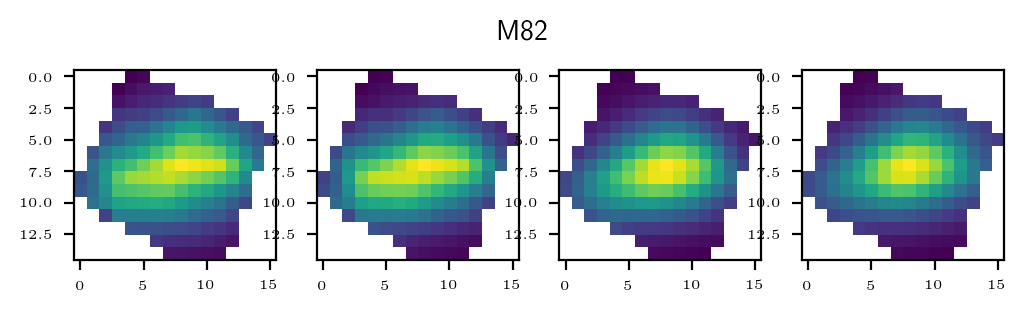

In [5]:
    # --------------------------------------------------- #
    # Check that the arrays are oriented in the same way. #
    # --------------------------------------------------- #
    labelSize = 5
    matplotlib.rcParams['xtick.labelsize'] = labelSize
    matplotlib.rcParams['ytick.labelsize'] = labelSize


    fig = plt.figure(figsize=(6,8),dpi=200, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.imshow(cii158CroppedMasked)
    ax2.imshow(oi145CroppedMasked)
    ax3.imshow(oiii88CroppedMasked)
    ax4.imshow(oi63CroppedMasked)


    fig.text(0.5, 0.58, objectName.upper(),ha='center',fontsize=10)

    plt.show()

In [6]:
    # ---------------------------------------------- #
    # Crop and mask the fitted continuum flux image. #
    # ---------------------------------------------- #
    for key in lineProfDict.keys():
        cropped = lineProfDict[key]['lineContFlux'][t[0]:t[1],t[2]:t[3]]
        masked = ma.masked_array(cropped,mask=samePixMask)
        lineProfDict[key].setdefault('lineContFluxCropMask',masked)    

In [7]:
    # ----------------------------------------------- #
    # Send each line and its continuum flux to arrays #
    # ----------------------------------------------- #
    lineContFluxes = np.zeros([4,nColsNew,nRowsNew])
    lineRestWaves = np.zeros([4,nColsNew,nRowsNew])
    for col,row in list(samePixList):
        tempFluxes = np.array([])
        tempRestWaves = np.array([])
        for key in lineProfDict.keys():
            if key != 'nii122':
                tempFluxes=np.append(tempFluxes,
                                     lineProfDict[key]['lineContFluxCropMask'][col,row])
                tempRestWaves=np.append(tempRestWaves,lineProfDict[key]['restWave'])

        lineContFluxes[:,col,row]=tempFluxes
        lineRestWaves[:,col,row]=tempRestWaves
    lineRestWaves = ma.masked_where(lineContFluxes==0,lineRestWaves)
    lineContFluxes = ma.masked_where(lineContFluxes==0,lineContFluxes)


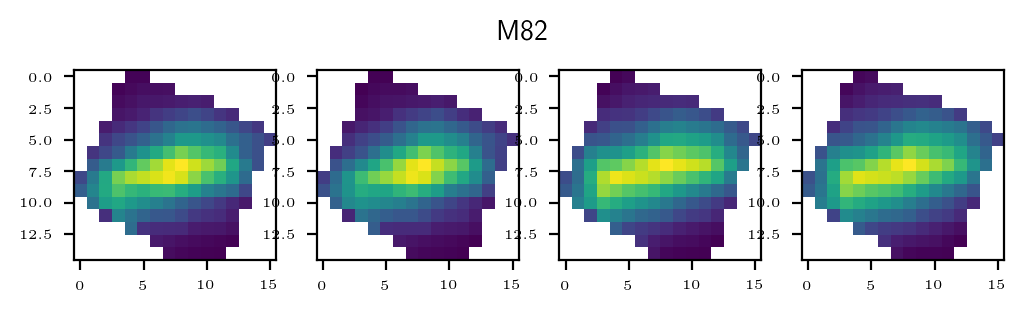

In [8]:
    # --------------------------------------------- #
    # Make a colormap of the continuum line fluxes. #
    # --------------------------------------------- #
    import matplotlib.pyplot as plt
    import matplotlib

    labelSize = 5
    matplotlib.rcParams['xtick.labelsize'] = labelSize
    matplotlib.rcParams['ytick.labelsize'] = labelSize


    fig = plt.figure(figsize=(6,8),dpi=200, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.imshow(lineContFluxes[0])
    ax2.imshow(lineContFluxes[1])
    ax3.imshow(lineContFluxes[2])
    ax4.imshow(lineContFluxes[3])

    fig.text(0.5, 0.58, objectName.upper(),ha='center',fontsize=10)

    plt.show()

In [9]:
D

2899416.9142857143

In [10]:
    # ----------------------------- #
    # Fit the greybody to the data. #
    # ----------------------------- #
    # Wavelengths to compute the blackbody spectrum
    wavelengths = np.arange(45,250,1)
    waveLog = np.log10(wavelengths)
    # Initial guesses for temp(K) and mass(M_solar)
    p0=[40,1e7]
    # Function to fit the SED
    def gbFit(iicolrow):
        ii,col,row=iicolrow
        popt, pcov = curve_fit(greybody,lineRestWaves[:,col,row],
                               lineContFluxes[:,col,row],p0,maxfev = 20000)
        return((col,row),popt)
    # Run parallel_map for gbFit
    sequence = [(ii,col,row) for ii,(col,row) in tuple(enumerate(samePixList))]
    result = parallel_map(gbFit, sequence, numcores=4)
    # Get the fitted dust mass and temperature
    dustTempMass = np.zeros((2,nColsNew,nRowsNew))
    for i in range(len(result)):
        col,row=int(result[i][0][0]),int(result[i][0][1])
        dustTempMass[:,col,row]=result[i][1]
    # Mask bad data.
    dustTempMass = ma.masked_where(dustTempMass==0,dustTempMass)

In [11]:
    # --------------------- #
    # Compute the TIR flux. #
    # --------------------- #
    i60 = greybody(60,dustTempMass[0,:,:],dustTempMass[1,:,:])
    i100 = greybody(100,dustTempMass[0,:,:],dustTempMass[1,:,:])
    firValue = fir(i60,i100)
    tirValue = 10**(.33)*firValue


    # --------------------------------------------------- #
    # Compute fluxes of the fitted greybody for plotting. #
    # --------------------------------------------------- #    
    gbWavesTemp = np.arange(45,250,1)
    gbWaves = np.zeros((len(gbWavesTemp),nColsNew,nRowsNew))
    for col in range(nColsNew):
        for row in range(nRowsNew):
            gbWaves[:,col,row] = gbWavesTemp
    gbFluxes = greybody(gbWaves,
                        dustTempMass[0,:,:],
                        dustTempMass[1,:,:])

In [13]:
    # ------------------------------------------- #
    # Plot the fitted BB SED and the data points. #
    # ------------------------------------------- #
    plotGBFit(dataFluxPoints=lineContFluxes,
              dataWavePoints=lineRestWaves,
              gbFluxes=gbFluxes,
              gbWaves=gbWaves,
              nColsRows=[nColsNew,nRowsNew],
              validPixels=samePixList,
              plotTitle=objectName.upper()+r' GB SED Fit ($\beta = 1$)',
              saveName=bbPlotSavePath+objectName+'_gbFit_b1.pdf')


    # ------------------------------------------------- #
    # Make a colormap of the dust temperature and mass. #
    # ------------------------------------------------- #
    cMapDustTempMass(dustTempMass,
                     wcs=pacsWcs[t[0]:t[1],t[2]:t[3]],wcsMinMax=wcsMinMax,
                     fluxImage=lineProfDict['oi63']['lineContFluxCropMask'],
                     raCenter=obsInfo.raCenter,decCenter=obsInfo.decCenter,
                     plotTitle=(objectName.upper()+' ([OI]63 Continuum Contours) '
                                +r'$\beta = 1$'),
                     saveName=bbPlotSavePath+objectName+'_dustTempMass_b1.pdf')


    # ---------------------------------- #
    # Make color maps of the TIR and FIR #
    # ---------------------------------- #
    cMapFirTir(tirValues=tirValue,firValues=firValue,
               wcs=pacsWcs[t[0]:t[1],t[2]:t[3]],wcsMinMax=wcsMinMax,
               raCenter=obsInfo.raCenter,decCenter=obsInfo.decCenter,
               fluxImage=lineProfDict['oi63']['lineContFluxCropMask'],
               plotTitle=(objectName.upper()+' ([OI]63 Continuum Contours) '+
                          r'$\beta = 1$'),
               saveName=bbPlotSavePath+objectName+'_tir_fir_b1.pdf')

The is_string_like function was deprecated in version 2.1.


In [14]:
    # -------------------------- #
    # Prep work for PDR Toolbox. #
    # -------------------------- #
    oi63Double=oi63*2
    
    #oi63Double = oi63*4.5
    cii158Corr = cii158 - (1.1*nii122)
    
    pdrParams = np.zeros((12,cii158.shape[0],cii158.shape[1]))
    # List of flux combos to compute the PDR parameters.
    convFluxList = np.concatenate((np.array((tirValue,cii158CroppedMasked,oi145CroppedMasked,oi63CroppedMasked)),
                                   np.array((tirValue,cii158Corr,oi145CroppedMasked,oi63CroppedMasked)),
                                   np.array((tirValue,cii158CroppedMasked,oi145,oi63Double)),
                                   np.array((tirValue,cii158Corr,oi145CroppedMasked,oi63Double))
                                 ))
    where_are_NaNs = np.isnan(convFluxList)
    convFluxList[where_are_NaNs] = 0

In [15]:
    # ----------------------------------------------- #
    # Run the PDR Toolbox and get the PDR parameters. #
    # ----------------------------------------------- #
    count = 0
    for ii in np.arange(0,len(convFluxList),4):
        if ii == 0 : setName = 'NoCorr'
        if ii == 4 : setName = 'Cii158Corr'
        if ii == 8 : setName = 'Oi63Corr'
        if ii == 12 : setName = 'BothCorr'

        if setName in ['Oi63Corr', 'BothCorr']:
            nmin, nmax = 5000, 1e7
            gmin = 0
        else:
            nmin, nmax =  0, 1e4
            gmin = 0

        # Where to save the model maps.
        savedir = pdrSavePath + 'webRatioPlots'+setName+'/'
        if (not os.path.exists(savedir)):os.makedirs(savedir)
        # Loop through valid pixels only.
        for col,row in samePixList:
            # Choose the four values for ratios.
            lineNames = ['FIR','CII_158','OI_145','OI_63']
            # Make the lists of fluxes and errors.
            convFlux = convFluxList[ii:ii+4,col,row]
            fluxErr = (np.array(convFlux)*.2).tolist()
            # Label for saving.
            suffix = '_col'+str(int(row))+'_row'+str(int(col))+'_'+setName

            # Get the parameters from the cropped chi2 parameter space.
            savePlots = False
            chisq,n,g0,url = pdrt_getvaluesV3(lineNames,convFlux,fluxErr,
                                              saveplots=savePlots,
                                              savedir=savedir,
                                              suffix=suffix,
                                              nmin=nmin,
                                              nmax=nmax,
                                              gmin=gmin)
            pdrParams[count:count+3,col,row]=[chisq,n,g0]


#             # # Don't create the ratio maps.
#             chisq,n,g0,url = pdrt_getvaluesV3(lineNames,convFlux,fluxErr)
#             pdrParams[count:count+3,col,row]=[chisq,n,g0]


        count += 3
        print 'PDR Fitting line set %d' % (ii)
    # Mask bad pixels.
    pdrParamsMasked = ma.masked_where(pdrParams==0.,pdrParams)

PDR Fitting line set 0
PDR Fitting line set 4
PDR Fitting line set 8
PDR Fitting line set 12


In [16]:
    # ----------------------------------- #
    # Find vMin/vMax to put the colormaps #
    # on the same colorbar scale.         #
    # ----------------------------------- #
    nMin = np.min([np.amin(pdrParamsMasked[1,:,:]),
                   np.amin(pdrParamsMasked[4,:,:]),
                   np.amin(pdrParamsMasked[7,:,:]),
                   np.amin(pdrParamsMasked[10,:,:])])
    nMax = np.max([np.amax(pdrParamsMasked[1,:,:]),
                   np.amax(pdrParamsMasked[4,:,:]),
                   np.amax(pdrParamsMasked[7,:,:]),
                   np.amax(pdrParamsMasked[10,:,:])])
    gMin = np.min([np.amin(pdrParamsMasked[2,:,:]),
                   np.amin(pdrParamsMasked[5,:,:]),
                   np.amin(pdrParamsMasked[8,:,:]),
                   np.amin(pdrParamsMasked[11,:,:])])
    gMax = np.max([np.amax(pdrParamsMasked[2,:,:]),
                   np.amax(pdrParamsMasked[5,:,:]),
                   np.amax(pdrParamsMasked[8,:,:]),
                   np.amax(pdrParamsMasked[11,:,:])])
    cmapMinMax = [nMin,nMax,gMin,gMax]

In [18]:
    # -------------------------------------- #
    # Make color maps of the PDR parameters. #
    # -------------------------------------- #
    savePlotSuffix = '_b1_chiCropped'
    plotTitle = ' PDR Results (4 Fluxes)'+r' $\beta=1\, x^2$-crop'

    cMapPdrParams4Fluxes(pdrParams=pdrParamsMasked,
                         wcs=pacsWcs[t[0]:t[1],t[2]:t[3]],
                         wcsMinMax=t,
                         raCenter=obsInfo.raCenter,
                         decCenter=obsInfo.decCenter,
                         objectName=objectName,
                         plotTitle=(objectName.upper()+plotTitle),
                         saveFileName=(pdrSavePath+objectName+
                                       '_4fluxes'+savePlotSuffix+'.pdf'),
                         cmapMinMax = None
                        )

    cMapPdrParams4FluxesNoWcs(pdrParams=pdrParamsMasked,
                              objectName=objectName,
                              plotTitle=(objectName.upper()+plotTitle),
                              saveFileName=(pdrSavePath+objectName+
                                            '_4fluxes'+savePlotSuffix+'_noWcs.pdf'),
                              cmapMinMax = cmapMinMax
                             )

Rasterization of '<matplotlib.collections.QuadMesh object at 0xb0c5147d0>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0xb0c8b01d0>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0xb0c4e2d90>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0xb0cad0a90>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c15451690>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c15518f50>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c1562e9d0>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c156c3550>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c158cde90>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c159dcd10>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c15a6ef90>' will be 